In [202]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Data generation

In [307]:
x_dim = 5 # dimension of observations
freq = 0.01 # frequency of class 2 samples
mu_1 = 5*np.random.randn(x_dim,1) # mean of class 1
mu_2 = 5*np.random.randn(x_dim,1) # mean of class 2
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 100000 # number of data points

In [308]:
class_1 = mu_1 + sig@np.random.randn(x_dim,int(samples*(1-freq)))
class_2 = mu_2 + sig@np.random.randn(x_dim,int(samples*freq))

In [309]:
X = np.concatenate((class_1,class_2),axis=1)
Y = np.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1
idx = np.random.permutation(samples)
X = X[:,idx]
Y = Y[:,idx]

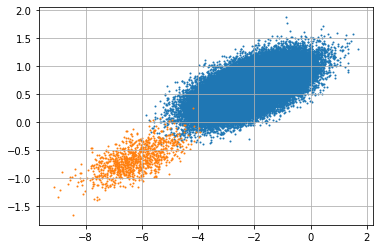

In [310]:
plt.scatter(class_1[0],class_1[1],s=1)
plt.scatter(class_2[0],class_2[1],s=1)
plt.grid()
plt.show()

### Optimal solution

In [311]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

In [312]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

### Offline algorithm

In [351]:
eta = 0.01; gam = 1000*eta; iters = 1000

In [352]:
w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

for i_iter in range(iters):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*(w.T@Sigma@w - 1)
    obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

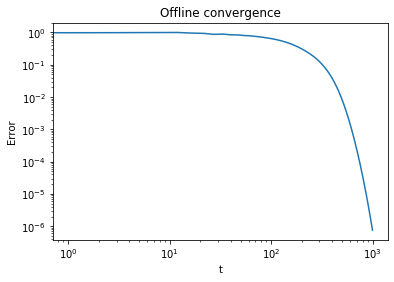

In [353]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

### Online algorithm

In [359]:
eta = 0.00001; gam = 1000*eta; epochs = 10; iters = epochs*samples

In [360]:
w = np.random.randn(x_dim)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

mu_1 = np.zeros(x_dim)
mu_2 = np.zeros(x_dim)

a = 0.5
b = 0.5

start_time = time.time()

for i_epoch in range(epochs):
    
    print(f'Epoch {i_epoch+1} of {epochs}:')
        
    idx = np.random.permutation(samples)
    
    for i_sample in range(samples):
        
        i_iter = i_epoch*samples + i_sample
        
        t = i_iter + 1
        
        x = X[:,idx[i_sample]]
        y = Y[:,idx[i_sample]]
        
        z = w.T@x

        a = max(a + (y[0]-a)/t,1e-5)
        b = max(b + (y[1]-b)/t,1e-5)
        
        mu_1 += ((y[0]/a)*x - mu_1)/t
        mu_2 += ((y[1]/b)*x - mu_2)/t

        mu = mu_1*y[0] + mu_2*y[1]
        nu = w.T@mu

        w += eta*(y[0]/a - y[1]/b)*x - eta*l*(z-nu)*(x-mu)
        l += gam*((z-nu)**2 - 1)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
        
    print(f'Elapsed time: {time.time()-start_time} seconds')
    print(f'Error: {err[i_iter]})

Epoch 1 of 10:
Elapsed time: 2.8177289962768555 seconds
Epoch 2 of 10:
Elapsed time: 5.643953800201416 seconds
Epoch 3 of 10:
Elapsed time: 8.521591901779175 seconds
Epoch 4 of 10:
Elapsed time: 11.466948747634888 seconds
Epoch 5 of 10:
Elapsed time: 14.295538902282715 seconds
Epoch 6 of 10:
Elapsed time: 17.141018867492676 seconds
Epoch 7 of 10:
Elapsed time: 20.018935918807983 seconds
Epoch 8 of 10:
Elapsed time: 22.898072004318237 seconds
Epoch 9 of 10:
Elapsed time: 25.77446985244751 seconds
Epoch 10 of 10:
Elapsed time: 28.64999485015869 seconds


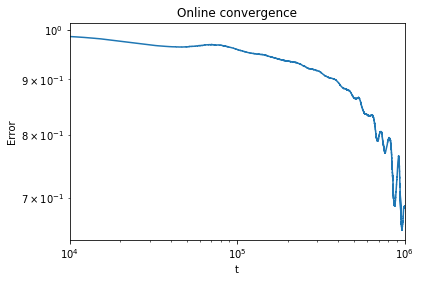

In [368]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e4,iters)
plt.title("Online convergence")
plt.show()

### Online algorithm for sparse class 2 samples

In [428]:
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 1000; epochs = 100; iters = epochs*samples

In [429]:
w = np.random.randn(x_dim)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

mu = np.zeros(x_dim)

b = 0.5

start_time = time.time()

for i_epoch in range(epochs):
    
    print(f'Epoch {i_epoch+1} of {epochs}:')
        
    idx = np.random.permutation(samples)
    
    for i_sample in range(samples):
        
        i_iter = i_epoch*samples + i_sample
        
        t = i_iter + 1
        
        x = X[:,idx[i_sample]]
        y = Y[:,idx[i_sample]]
        
        z = w.T@x

        b = max(b + (y[1]-b)/t,1e-5)
        
        mu += (x - mu)/t
        nu = w.T@mu
        
        step = eta(t)

        w += step*(x - l*(z-nu)*(x-mu)) - step*y[1]*x/b
        l += gam*step*((z-nu)**2 - 1)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
        
    print(f'Elapsed time: {time.time()-start_time} seconds')

Epoch 1 of 100:
Elapsed time: 2.198133945465088 seconds
Epoch 2 of 100:
Elapsed time: 4.468079090118408 seconds
Epoch 3 of 100:
Elapsed time: 6.976285219192505 seconds
Epoch 4 of 100:
Elapsed time: 9.29306411743164 seconds
Epoch 5 of 100:
Elapsed time: 11.602851152420044 seconds
Epoch 6 of 100:
Elapsed time: 14.04557728767395 seconds
Epoch 7 of 100:
Elapsed time: 16.793415069580078 seconds
Epoch 8 of 100:
Elapsed time: 19.16229510307312 seconds
Epoch 9 of 100:
Elapsed time: 21.579488039016724 seconds
Epoch 10 of 100:
Elapsed time: 23.88099193572998 seconds
Epoch 11 of 100:
Elapsed time: 26.17793917655945 seconds
Epoch 12 of 100:
Elapsed time: 28.477144956588745 seconds
Epoch 13 of 100:
Elapsed time: 30.763123989105225 seconds
Epoch 14 of 100:
Elapsed time: 33.0334849357605 seconds
Epoch 15 of 100:
Elapsed time: 35.336510181427 seconds
Epoch 16 of 100:
Elapsed time: 37.65722608566284 seconds
Epoch 17 of 100:
Elapsed time: 39.96463418006897 seconds
Epoch 18 of 100:
Elapsed time: 42.26544

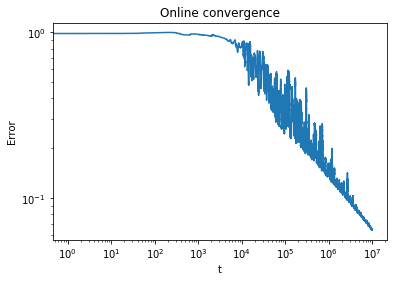

In [432]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
# plt.xlim(1e4,iters)
plt.title("Online convergence")
plt.show()